In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import gc
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from concurrent.futures import ThreadPoolExecutor

from yellowbrick.classifier import ConfusionMatrix

import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
def convert_to_integer(value):
    if pd.isna(value) or value == '':
        return None
    elif isinstance(value, int) or isinstance(value, float):
        return value
    else:
        # Adjusting the split to handle both hyphens and commas
        signal_strengths = [int(v) for v in value.replace(',', '-').split('-') if v]
        if signal_strengths:
            average_strength = round(sum(signal_strengths) / len(signal_strengths))
            return -average_strength
        else:
            return None

In [5]:
def check_special_characters(feature_names):
    for feature_name in feature_names:
        if not re.match("^[a-zA-Z0-9_]*$", feature_name):
            print("Special character found in feature name:", feature_name)

In [6]:
features = ['frame.interface_id',
 'frame.dlt',
 'frame.offset_shift',
 'frame.time_epoch',
 'frame.time_delta',
 'frame.time_delta_displayed',
 'frame.time_relative',
 'frame.len',
 'frame.cap_len',
 'frame.marked',
 'frame.ignored',
 'radiotap.version',
 'radiotap.pad',
 'radiotap.length',
 'radiotap.present.tsft',
 'radiotap.present.flags',
 'radiotap.present.rate',
 'radiotap.present.channel',
 'radiotap.present.fhss',
 'radiotap.present.dbm_antsignal',
 'radiotap.present.dbm_antnoise',
 'radiotap.present.lock_quality',
 'radiotap.present.tx_attenuation',
 'radiotap.present.db_tx_attenuation',
 'radiotap.present.dbm_tx_power',
 'radiotap.present.antenna',
 'radiotap.present.db_antsignal',
 'radiotap.present.db_antnoise',
 'radiotap.present.rxflags',
 'radiotap.present.xchannel',
 'radiotap.present.mcs',
 'radiotap.present.ampdu',
 'radiotap.present.vht',
 'radiotap.present.reserved',
 'radiotap.present.rtap_ns',
 'radiotap.present.vendor_ns',
 'radiotap.present.ext',
 'radiotap.mactime',
 'radiotap.flags.cfp',
 'radiotap.flags.preamble',
 'radiotap.flags.wep',
 'radiotap.flags.frag',
 'radiotap.flags.fcs',
 'radiotap.flags.datapad',
 'radiotap.flags.badfcs',
 'radiotap.flags.shortgi',
 'radiotap.datarate',
 'radiotap.channel.freq',
 'radiotap.channel.type.turbo',
 'radiotap.channel.type.cck',
 'radiotap.channel.type.ofdm',
 'radiotap.channel.type.2ghz',
 'radiotap.channel.type.5ghz',
 'radiotap.channel.type.passive',
 'radiotap.channel.type.dynamic',
 'radiotap.channel.type.gfsk',
 'radiotap.channel.type.gsm',
 'radiotap.channel.type.sturbo',
 'radiotap.channel.type.half',
 'radiotap.channel.type.quarter',
 'radiotap.dbm_antsignal',
 'radiotap.antenna',
 'radiotap.rxflags.badplcp',
 'wlan.fc.type_subtype',
 'wlan.fc.version',
 'wlan.fc.type',
 'wlan.fc.subtype',
 'wlan.fc.ds',
 'wlan.fc.frag',
 'wlan.fc.retry',
 'wlan.fc.pwrmgt',
 'wlan.fc.moredata',
 'wlan.fc.protected',
 'wlan.fc.order',
 'wlan.duration',
 'wlan.ra',
 'wlan.da',
 'wlan.ta',
 'wlan.sa',
 'wlan.bssid',
 'wlan.frag',
 'wlan.seq',
 'wlan.bar.type',
 'wlan.ba.control.ackpolicy',
 'wlan.ba.control.multitid',
 'wlan.ba.control.cbitmap',
 'wlan.bar.compressed.tidinfo',
 'wlan.ba.bm',
 'wlan.fcs_good',
 'wlan_mgt.fixed.capabilities.ess',
 'wlan_mgt.fixed.capabilities.ibss',
 'wlan_mgt.fixed.capabilities.cfpoll.ap',
 'wlan_mgt.fixed.capabilities.privacy',
 'wlan_mgt.fixed.capabilities.preamble',
 'wlan_mgt.fixed.capabilities.pbcc',
 'wlan_mgt.fixed.capabilities.agility',
 'wlan_mgt.fixed.capabilities.spec_man',
 'wlan_mgt.fixed.capabilities.short_slot_time',
 'wlan_mgt.fixed.capabilities.apsd',
 'wlan_mgt.fixed.capabilities.radio_measurement',
 'wlan_mgt.fixed.capabilities.dsss_ofdm',
 'wlan_mgt.fixed.capabilities.del_blk_ack',
 'wlan_mgt.fixed.capabilities.imm_blk_ack',
 'wlan_mgt.fixed.listen_ival',
 'wlan_mgt.fixed.current_ap',
 'wlan_mgt.fixed.status_code',
 'wlan_mgt.fixed.timestamp',
 'wlan_mgt.fixed.beacon',
 'wlan_mgt.fixed.aid',
 'wlan_mgt.fixed.reason_code',
 'wlan_mgt.fixed.auth.alg',
 'wlan_mgt.fixed.auth_seq',
 'wlan_mgt.fixed.category_code',
 'wlan_mgt.fixed.htact',
 'wlan_mgt.fixed.chanwidth',
 'wlan_mgt.fixed.fragment',
 'wlan_mgt.fixed.sequence',
 'wlan_mgt.tagged.all',
 'wlan_mgt.ssid',
 'wlan_mgt.ds.current_channel',
 'wlan_mgt.tim.dtim_count',
 'wlan_mgt.tim.dtim_period',
 'wlan_mgt.tim.bmapctl.multicast',
 'wlan_mgt.tim.bmapctl.offset',
 'wlan_mgt.country_info.environment',
 'wlan_mgt.rsn.version',
 'wlan_mgt.rsn.gcs.type',
 'wlan_mgt.rsn.pcs.count',
 'wlan_mgt.rsn.akms.count',
 'wlan_mgt.rsn.akms.type',
 'wlan_mgt.rsn.capabilities.preauth',
 'wlan_mgt.rsn.capabilities.no_pairwise',
 'wlan_mgt.rsn.capabilities.ptksa_replay_counter',
 'wlan_mgt.rsn.capabilities.gtksa_replay_counter',
 'wlan_mgt.rsn.capabilities.mfpr',
 'wlan_mgt.rsn.capabilities.mfpc',
 'wlan_mgt.rsn.capabilities.peerkey',
 'wlan_mgt.tcprep.trsmt_pow',
 'wlan_mgt.tcprep.link_mrg',
 'wlan.wep.iv',
 'wlan.wep.key',
 'wlan.wep.icv',
 'wlan.tkip.extiv',
 'wlan.ccmp.extiv',
 'wlan.qos.tid',
 'wlan.qos.priority',
 'wlan.qos.eosp',
 'wlan.qos.ack',
 'wlan.qos.amsdupresent',
 'wlan.qos.buf_state_indicated1',
 'wlan.qos.bit4',
 'wlan.qos.txop_dur_req',
 'wlan.qos.buf_state_indicated2',
 'data.len',
 'class']

selected_features = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration', 'radiotap.present.tsft', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected', 'class']

### Reading AWID2 CLS-R-Train

In [7]:
awid2_data = pd.read_csv("/content/drive/MyDrive/AWID/AWID2/DATASET/AWID-CLS-R-Trn/AWID-CLS-R-Trn/1", header=None, names=features, low_memory=False)

awid2_data = awid2_data.loc[:, selected_features]
pd.set_option('display.max_columns', None)

awid2_data.head(10)

,frame.len,radiotap.length,radiotap.dbm_antsignal,wlan.duration,radiotap.present.tsft,wlan.fc.type,wlan.fc.subtype,wlan.fc.ds,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected,class
0,261,26,-47,0,1,0,8,0x00,0,0,0,0,0,normal
1,185,26,-47,0,1,0,8,0x00,0,0,0,0,0,normal
2,185,26,-64,0,1,0,8,0x00,0,0,0,0,0,normal
3,159,26,-32,0,1,0,8,0x00,0,0,0,0,0,normal
4,54,26,-21,44,1,2,4,0x01,0,0,0,0,0,normal
5,40,26,-24,0,1,1,13,0x00,0,0,0,0,0,normal
6,261,26,-47,0,1,0,8,0x00,0,0,0,0,0,normal
7,40,26,-24,0,1,1,13,0x00,0,0,0,0,0,normal
8,185,26,-52,0,1,0,8,0x00,0,0,0,0,0,normal
9,185,26,-58,0,1,0,8,0x00,0,0,0,0,0,normal


In [8]:
awid2_data.rename(columns={'class': 'Label'}, inplace=True)

### Reading AWID3 Deauth

In [10]:
main_folder_path = "/content/drive/MyDrive/AWID/CSV/1.Deauth"
columns_to_read = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration', 'radiotap.present.tsft', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected', 'Label']

csv_files = glob.glob(f"{main_folder_path}/*.csv", recursive=True)

def read_csv(file):
    return pd.read_csv(file, usecols=columns_to_read)

# Use ThreadPoolExecutor for parallel file reading
with ThreadPoolExecutor(max_workers=2) as executor:
    dfs = list(executor.map(read_csv, glob.glob(f"{main_folder_path}/*.csv")))

    # Concatenate all DataFrames
awid3_data = pd.concat(dfs, ignore_index=True)

In [11]:
del dfs
awid3_data = reduce_mem_usage(awid3_data)

Memory usage of dataframe is 173.73 MB
Memory usage after optimization is: 26.41 MB
Decreased by 84.8%


In [12]:
awid3_data['Label'] = awid3_data['Label'].replace('Deauth', 'flooding')

<ipython-input-12-3127362492>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  awid3_data['Label'] = awid3_data['Label'].replace('Deauth', 'flooding')


In [13]:
awid2_data = awid2_data[awid2_data['Label'].isin(['normal', 'flooding'])]

In [14]:
awid2_data = awid2_data.replace(r'^\s*$', pd.NA, regex=True)
awid2_data = awid2_data.replace('?', pd.NA)
awid2_data = awid2_data.dropna()

In [15]:
awid3_data = awid3_data.replace(r'^\s*$', pd.NA, regex=True)
awid3_data = awid3_data.replace('?', pd.NA)
awid3_data = awid3_data.dropna()

In [16]:
X_awid2 = awid2_data.loc[:, ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration', 'radiotap.present.tsft', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected']]
y_awid2 = awid2_data[['Label']]

In [17]:
X_awid3 = awid3_data.loc[:, ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration', 'radiotap.present.tsft', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected']]
y_awid3 = awid3_data[['Label']]

In [18]:
y_awid3.loc[:, 'Label'] = y_awid3['Label'].replace('Normal', 'normal')

<ipython-input-18-3689179606>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_awid3.loc[:, 'Label'] = y_awid3['Label'].replace('Normal', 'normal')
<ipython-input-18-3689179606>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['normal', 'normal', 'normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal', 'normal', 'normal']
Length: 1626469
Categories (2, object): ['flooding', 'normal']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  y_awid3.loc[:, 'Label'] = y_awid3['Label'].replace('Normal', 'normal')


In [19]:
X_awid2['radiotap.dbm_antsignal'] = X_awid2['radiotap.dbm_antsignal'].apply(convert_to_integer)

In [20]:
X_awid3['radiotap.dbm_antsignal'] = X_awid3['radiotap.dbm_antsignal'].apply(convert_to_integer)

## Encoding

In [21]:
columns_to_scale = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration']
columns_to_one_hot_encode = [col for col in X_awid2.columns if col not in columns_to_scale]

# Min-max scaling
scaler = MinMaxScaler()
X_awid2[columns_to_scale] = scaler.fit_transform(X_awid2[columns_to_scale])

scaler = MinMaxScaler()
X_awid3[columns_to_scale] = scaler.fit_transform(X_awid3[columns_to_scale])

# One-hot encoding
combined_data = pd.concat([X_awid2, X_awid3], axis=0) # Combine dataframes
combined_data = pd.get_dummies(combined_data, columns=columns_to_one_hot_encode)
X_awid2_encoded = combined_data[:len(X_awid2)]
X_awid3_encoded = combined_data[len(X_awid2):]

In [22]:
X_awid2_encoded

,frame.len,radiotap.length,radiotap.dbm_antsignal,wlan.duration,radiotap.present.tsft_1,radiotap.present.tsft_0-0-0,radiotap.present.tsft_1-0-0,wlan.fc.type_0,wlan.fc.type_1,wlan.fc.type_2,wlan.fc.subtype_0,wlan.fc.subtype_1,wlan.fc.subtype_2,wlan.fc.subtype_3,wlan.fc.subtype_4,wlan.fc.subtype_5,wlan.fc.subtype_8,wlan.fc.subtype_9,wlan.fc.subtype_10,wlan.fc.subtype_11,wlan.fc.subtype_12,wlan.fc.subtype_13,wlan.fc.subtype_14,wlan.fc.subtype_15,wlan.fc.ds_0x00,wlan.fc.ds_0x00000000,wlan.fc.ds_0x00000001,wlan.fc.ds_0x00000002,wlan.fc.ds_0x00000003,wlan.fc.ds_0x01,wlan.fc.ds_0x02,wlan.fc.frag_0,wlan.fc.frag_1,wlan.fc.retry_0,wlan.fc.retry_1,wlan.fc.pwrmgt_0,wlan.fc.pwrmgt_1,wlan.fc.moredata_0,wlan.fc.moredata_1,wlan.fc.protected_0,wlan.fc.protected_1
0,0.144444,0.0,0.369231,0.000000,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
1,0.094771,0.0,0.369231,0.000000,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
2,0.094771,0.0,0.107692,0.000000,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
3,0.077778,0.0,0.600000,0.000000,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
4,0.009150,0.0,0.769231,0.003034,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795570,0.000000,0.0,0.707692,0.000000,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
1795571,0.070588,0.0,0.200000,0.000000,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
1795572,0.009150,0.0,0.676923,0.003034,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False
1795573,0.000000,0.0,0.707692,0.000000,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False


In [23]:
X_awid3_encoded

,frame.len,radiotap.length,radiotap.dbm_antsignal,wlan.duration,radiotap.present.tsft_1,radiotap.present.tsft_0-0-0,radiotap.present.tsft_1-0-0,wlan.fc.type_0,wlan.fc.type_1,wlan.fc.type_2,wlan.fc.subtype_0,wlan.fc.subtype_1,wlan.fc.subtype_2,wlan.fc.subtype_3,wlan.fc.subtype_4,wlan.fc.subtype_5,wlan.fc.subtype_8,wlan.fc.subtype_9,wlan.fc.subtype_10,wlan.fc.subtype_11,wlan.fc.subtype_12,wlan.fc.subtype_13,wlan.fc.subtype_14,wlan.fc.subtype_15,wlan.fc.ds_0x00,wlan.fc.ds_0x00000000,wlan.fc.ds_0x00000001,wlan.fc.ds_0x00000002,wlan.fc.ds_0x00000003,wlan.fc.ds_0x01,wlan.fc.ds_0x02,wlan.fc.frag_0,wlan.fc.frag_1,wlan.fc.retry_0,wlan.fc.retry_1,wlan.fc.pwrmgt_0,wlan.fc.pwrmgt_1,wlan.fc.moredata_0,wlan.fc.moredata_1,wlan.fc.protected_0,wlan.fc.protected_1
0,0.085053,0.5,0.973684,0.000000,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
1,0.085053,0.5,0.973684,0.000000,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
2,0.020638,0.5,0.969298,0.000000,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,True
3,0.026266,0.5,0.969298,0.000000,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,True
4,0.085053,0.5,0.964912,0.000000,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626464,0.000000,0.5,0.631579,0.003685,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
1626465,0.085053,0.5,0.631579,0.000000,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False
1626466,0.004378,0.5,0.188596,0.001530,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,True,False,True,False
1626467,0.000000,0.5,0.631579,0.000000,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False


In [24]:
y_awid3['Label'].value_counts()

,count
Label,
normal,1587527
flooding,38942


In [25]:
def evaluate_classifier(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=1)
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    auc_micro = roc_auc_score(y_test, y_pred_proba, average='micro')

    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')

    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    auc_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted')

    accuracy = accuracy_score(y_test, y_pred)

    classes = ["flooding", "normal"]
    cm = confusion_matrix(y_test, y_pred)

    results = [
        [precision_micro, recall_micro, f1_micro, auc_micro],
        [precision_macro, recall_macro, f1_macro, auc_macro],
        [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
        accuracy,
        cm
    ]

    return results

In [26]:
def evaluate_classifier_linearsvc(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)

    decision_scores = classifier.decision_function(X_test)

    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=1)
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    auc_micro = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='micro')

    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc_macro = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='macro')

    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    auc_weighted = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='weighted')

    accuracy = accuracy_score(y_test, y_pred)

    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    cm = confusion_matrix(y_test, y_pred)

    results = [
        [precision_micro, recall_micro, f1_micro, auc_micro],
        [precision_macro, recall_macro, f1_macro, auc_macro],
        [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
        accuracy,
        cm
    ]

    return results

In [27]:
def train_and_eval_logistic_regression(X_train, y_train, X_test, y_test):
    # Convert the target variable to integer codes
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    # Create a Logistic Regression classifier with specified parameters
    logreg_model = LogisticRegression(
        solver='sag',
        max_iter=1000,
        tol=0.01,
        random_state=42,
        n_jobs=-1
    )

    # Train the Logistic Regression model
    logreg_model.fit(X_train, y_train)

    return evaluate_classifier(logreg_model, X_test, y_test)

In [28]:
def train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test):
    # Convert the target variable to integer codes
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    # Create an SGD Classifier with specified parameters
    sgd_model = SGDClassifier(
        tol=1e-05,
        loss='modified_huber',
        early_stopping=True,
        n_jobs=-1,
        random_state=42
    )

    # Train the SGD model
    sgd_model.fit(X_train, y_train)

    return evaluate_classifier(sgd_model, X_test, y_test)

In [29]:
def train_and_eval_linearsvc(X_train, y_train, X_test, y_test):
    # Convert the target variable to integer codes
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    svc_model = LinearSVC(max_iter=20000, C=1.5, random_state=42)

    # Train the LinearSVC model
    svc_model.fit(X_train, y_train)

    return evaluate_classifier_linearsvc(svc_model, X_test, y_test)

In [30]:
def train_and_eval_lightgbm(X_train, y_train, X_test, y_test):
    # Convert the target variable to integer codes
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    # Set the parameters for the LightGBM model
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 20,
        'learning_rate': 0.01,
        'max_bin': 20,
        'max_depth': 10,
        'min_child_samples': 30,
        'min_data_in_bin': 10,
        'min_split_gain': 0.1,
        'n_estimators': 80,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01,
        'n_jobs': -1,
        'verbose': -1
    }

    # Train the LightGBM model
    #lgb_model = lgb.train(params, train_data, valid_sets=[test_data])

    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train)

    return evaluate_classifier(lgb_model, X_test, y_test)

In [31]:
def train_and_eval_decision_tree(X_train, y_train, X_test, y_test):
    # Convert the target variable to integer codes
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    # Create a Decision Tree classifier with specified parameters
    dt_model = DecisionTreeClassifier(
        max_depth=20,
        ccp_alpha=0.001,
        max_leaf_nodes=100,
        min_samples_leaf=2,
        random_state=42
    )

    # Train the Decision Tree model
    dt_model.fit(X_train, y_train)

    return evaluate_classifier(dt_model, X_test, y_test)

In [32]:
def train_and_eval_random_forest(X_train, y_train, X_test, y_test):
    # Convert the target variable to integer codes
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    # Create a Random Forest classifier with specified hyperparameters
    rf_model = RandomForestClassifier(
        max_depth=20,
        ccp_alpha=0.001,
        max_leaf_nodes=100,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    # Train the Random Forest model
    rf_model.fit(X_train, y_train)

    return evaluate_classifier(rf_model, X_test, y_test)

In [33]:
def train_and_eval_extra_trees(X_train, y_train, X_test, y_test):
    # Convert the target variable to integer codes
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    # Create an Extra Trees classifier with specified parameters
    et_model = ExtraTreesClassifier(
        max_depth=200,
        n_estimators=200,
        ccp_alpha=0.0001,
        max_leaf_nodes=500,
        min_samples_leaf=2,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    )

    # Train the Extra Trees model
    et_model.fit(X_train, y_train)

    return evaluate_classifier(et_model, X_test, y_test)

In [34]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 10))

    #vmax = 320000
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [35]:
def print_results(name, results):
    classes = ["flooding", "normal"]
    print(f"\n{name}")

    print(f"Micro Precision: {results[0][0]}")
    print(f"Micro Recall: {results[0][1]}")
    print(f"Micro F1: {results[0][2]}")
    print(f"Micro AUC: {results[0][3]}")

    print(f"Macro Precision: {results[1][0]}")
    print(f"Macro Recall: {results[1][1]}")
    print(f"Macro F1: {results[1][2]}")
    print(f"Macro AUC: {results[1][3]}")

    print(f"Weighted Precision: {results[2][0]}")
    print(f"Weighted Recall: {results[2][1]}")
    print(f"Weighted F1: {results[2][2]}")
    print(f"Weighted AUC: {results[2][3]}")

    print(f"Accuracy: {results[3]}")

    plot_confusion_matrix(results[4], classes, f'Combined Confusion Matrix for {name}')

In [36]:
X_train, y_train = X_awid2_encoded, y_awid2
X_test, y_test = X_awid3_encoded, y_awid3

In [37]:
value_counts = y_test['Label'].value_counts()
value_counts

,count
Label,
normal,1587527
flooding,38942



Logistic Regression
Micro Precision: 0.9798655861255271
Micro Recall: 0.9798655861255271
Micro F1: 0.9798655861255271
Micro AUC: 0.971558394243833
Macro Precision: 0.9619221641089213
Macro Recall: 0.5844381933287038
Macro F1: 0.6383176673369454
Macro AUC: 0.971558394243833
Weighted Precision: 0.979154220026353
Weighted Recall: 0.9798655861255271
Weighted F1: 0.9729583420754165
Weighted AUC: 0.971558394243833
Accuracy: 0.9798655861255271


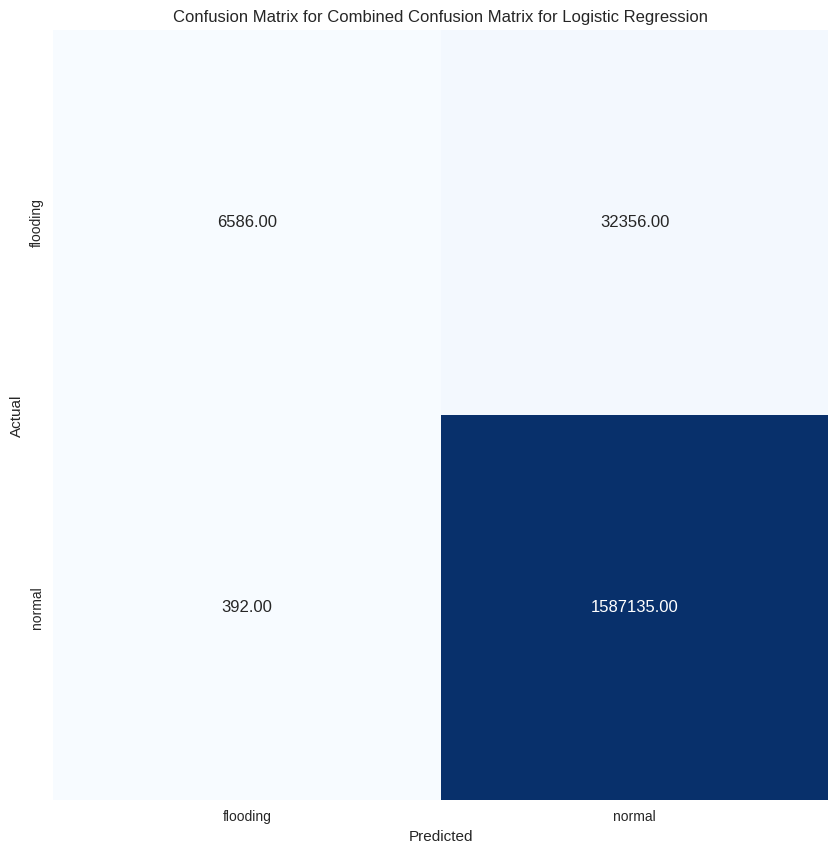

In [38]:
results = train_and_eval_logistic_regression(X_train, y_train, X_test, y_test)
print_results("Logistic Regression", results)

In [39]:
#results = train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test)
#print_results("SGDClassifier", results)

In [40]:
#results = train_and_eval_linearsvc(X_train, y_train, X_test, y_test)
#print_results("LinearSVC", results)

In [41]:
#results = train_and_eval_lightgbm(X_train, y_train, X_test, y_test)
#print_results("LightGBM", results)

In [42]:
#results = train_and_eval_decision_tree(X_train, y_train, X_test, y_test)
#print_results("Decision Tree", results)


Random Forest
Micro Precision: 0.9798170146495261
Micro Recall: 0.9798170146495261
Micro F1: 0.9798170146495261
Micro AUC: 0.997062915794419
Macro Precision: 0.9854690377389637
Macro Recall: 0.5792030564851909
Macro F1: 0.6314873649647444
Macro AUC: 0.997062915794419
Weighted Precision: 0.9800461535127205
Weighted Recall: 0.9798170146495261
Weighted F1: 0.9726101046799334
Weighted AUC: 0.997062915794419
Accuracy: 0.9798170146495261


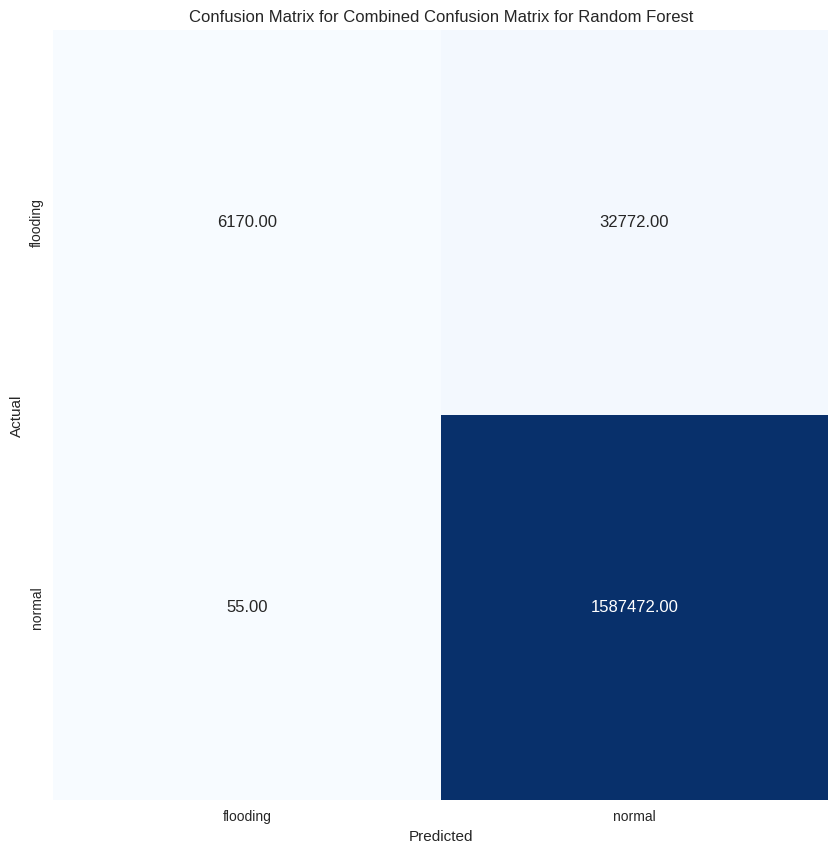

In [43]:
results = train_and_eval_random_forest(X_train, y_train, X_test, y_test)
print_results("Random Forest", results)


Extra Trees
Micro Precision: 0.9798274667392984
Micro Recall: 0.9798274667392984
Micro F1: 0.9798274667392984
Micro AUC: 0.9996292232032914
Macro Precision: 0.9856430997863904
Macro Recall: 0.5793962805100612
Macro F1: 0.6317826931673605
Macro AUC: 0.9996292232032914
Weighted Precision: 0.9800631486328036
Weighted Recall: 0.9798274667392984
Weighted F1: 0.9726292529561781
Weighted AUC: 0.9996292232032914
Accuracy: 0.9798274667392984


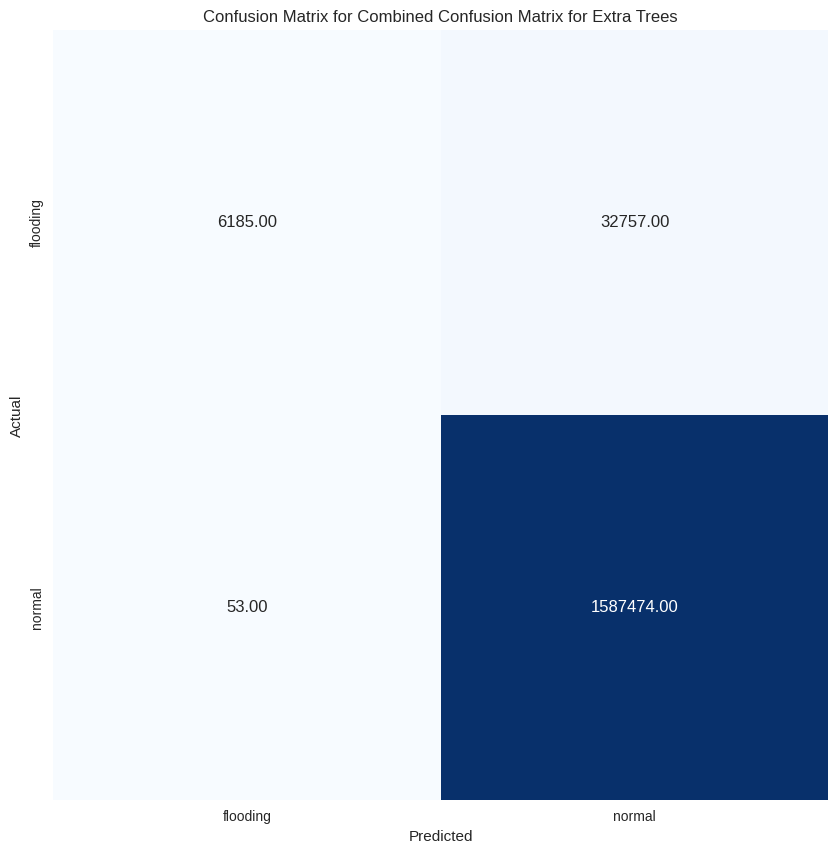

In [44]:
results = train_and_eval_extra_trees(X_train, y_train, X_test, y_test)
print_results("Extra Trees", results)